# Análise  e Coleta de Dados de Ações.

In [2]:
import yfinance as yf
import sqlite3
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta
import numpy as np

In [ ]:
# Função para baixar e armazenar dados no banco de dados SQLite
def salvar_dados_historicos(ticker):
    # Baixa os dados históricos desde a listagem inicial do ativo
    dados = yf.download(ticker, interval="1d")

    if dados.empty:
        print(f"Nenhum dado encontrado para o ativo {ticker}. Verifique o ticker e tente novamente.")
        return

    dados['Ticker'] = ticker

    conn = sqlite3.connect('finance.bd')
    cursor = conn.cursor()

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS historico_precos (
            Date TEXT,
            Open REAL,
            High REAL,
            Low REAL,
            Close REAL,
            "Adj Close" REAL,
            Volume INTEGER,
            Ticker TEXT
        )
    ''')

    dados.reset_index(inplace=True)
    dados.to_sql('historico_precos', conn, if_exists='append', index=False)
    conn.commit()
    conn.close()

    print(f"\n Dados históricos para {ticker} foram salvos em finance.bd.")

ativo = input("Digite o ticker do ativo (exemplo: KNCR11.SA): ")
salvar_dados_historicos(ativo)


Digite o ticker do ativo (exemplo: KNCR11.SA): AAPL34.SA


[*********************100%***********************]  1 of 1 completed

Dados históricos para AAPL34.SA foram salvos em finance.bd.


In [ ]:
# Função para obter a lista de ativos únicos no banco de dados
def obter_lista_tickers(conn):
    query = "SELECT DISTINCT Ticker FROM historico_precos"
    tickers = pd.read_sql_query(query, conn)
    return tickers['Ticker'].tolist()

# Função para obter a data mais recente de um ativo específico no banco
def obter_data_mais_recente(conn, ticker):
    query = f"SELECT MAX(Date) as max_date FROM historico_precos WHERE Ticker = '{ticker}'"
    data = pd.read_sql_query(query, conn)
    return data['max_date'][0]

# Função para atualizar dados históricos para cada ativo no banco
def atualizar_dados():
    # Conecta ao banco de dados
    conn = sqlite3.connect('finance.bd')

    # Obter a lista de tickers armazenados no banco
    tickers = obter_lista_tickers(conn)

    for ticker in tickers:
        # Obter a data mais recente para o ticker
        data_mais_recente = obter_data_mais_recente(conn, ticker)

        # Caso não haja dados, pule para o próximo ticker
        if not data_mais_recente:
            print(f"Nenhum dado encontrado para o ativo {ticker}. Pulando...")
            continue

        # Defina a data de início para um dia após a data mais recente
        start_date = pd.to_datetime(data_mais_recente) + pd.Timedelta(days=1)
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

        # Baixa novos dados históricos
        novos_dados = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date, interval="1d")

        if novos_dados.empty:
            print(f"Sem novos dados para o ativo {ticker}.")
            continue

        # Adiciona a coluna Ticker e ajusta o índice de data
        novos_dados['Ticker'] = ticker
        novos_dados.reset_index(inplace=True)

        # Insere os novos dados no banco de dados
        novos_dados.to_sql('historico_precos', conn, if_exists='append', index=False)
        print(f"Dados atualizados para {ticker} de {start_date.date()} até {end_date}.")

    # Fecha a conexão com o banco
    conn.close()

# Executa a função de atualização
atualizar_dados()


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL34.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-10-22 -> 2024-10-21) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1729566000, endDate = 1729479600")')


Sem novos dados para o ativo AAPL34.SA.


In [ ]:
# Função para calcular a data inicial com base no intervalo
def calcular_data_inicio(intervalo):
    hoje = datetime.today()
    if intervalo == '7d':
        return hoje - timedelta(days=7)
    elif intervalo == '3m':
        return hoje - timedelta(days=90)
    elif intervalo == '6m':
        return hoje - timedelta(days=180)
    elif intervalo == '1y':
        return hoje - timedelta(days=365)
    elif intervalo == '2y':
        return hoje - timedelta(days=2*365)
    elif intervalo == '5y':
        return hoje - timedelta(days=5*365)
    elif intervalo == '10y':
        return hoje - timedelta(days=10*365)
    elif intervalo == 'all':
        return None  # Para filtrar posteriormente com base nos dados disponíveis

# Função para plotar o gráfico interativo
def plotar_grafico(ticker, intervalo):
    # Conectar ao banco de dados
    conn = sqlite3.connect('finance.bd')

    # Ler os dados do banco para o ticker
    query = f"SELECT Date, Close FROM historico_precos WHERE Ticker = '{ticker}'"
    dados = pd.read_sql_query(query, conn)

    # Fechar a conexão com o banco
    conn.close()

    # Converter a coluna 'Date' para o tipo datetime
    dados['Date'] = pd.to_datetime(dados['Date'])

    # Filtrar os dados pelo intervalo de tempo
    data_inicio = calcular_data_inicio(intervalo)
    if data_inicio:
        dados = dados[dados['Date'] >= data_inicio]

    # Garantir que os dados estejam ordenados por data
    dados.sort_values('Date', inplace=True)

    # Plotar o gráfico
    fig = px.line(dados, x='Date', y='Close', title=f"{ticker} - Histórico de Preço",
                  labels={"Close": "Preço de Fechamento (R$)", "Date": "Data"})
    fig.update_traces(mode='lines+markers', hovertemplate='Data: %{x}<br>Preço de Fechamento: R$%{y:.2f}')

    # Exibir o gráfico
    fig.show()

    # Cálculo de variação
    if len(dados) > 1:
        valor_inicial = dados.iloc[0]['Close']
        valor_final = dados.iloc[-1]['Close']
        variacao_bruta = valor_final - valor_inicial
        variacao_percentual = (variacao_bruta / valor_inicial) * 100
        print(f"Variação de {ticker} no período de {intervalo}:")
        print(f"   - Valor inicial: R${valor_inicial:.2f}")
        print(f"   - Valor final: R${valor_final:.2f}")
        print(f"   - Variação bruta: R${variacao_bruta:.2f}")
        print(f"   - Variação percentual: {variacao_percentual:.2f}%")
    else:
        print("Não há dados suficientes para calcular a variação.")

ticker = input("Digite o ticker do ativo (exemplo: KNCR11.SA): ")
intervalo = input("Escolha o intervalo (7d, 3m, 6m, 1y, 2y, 5y, 10y, all): ")
plotar_grafico(ticker, intervalo)

Digite o ticker do ativo (exemplo: KNCR11.SA): AAPL34.SA
Escolha o intervalo (7d, 3m, 6m, 1y, 2y, 5y, 10y, all): 1Y


Variação de AAPL34.SA no período de 1Y:
   - Valor inicial: R$1.58
   - Valor final: R$67.34
   - Variação bruta: R$65.76
   - Variação percentual: 4156.25%


In [ ]:
# Função para exibir detalhes do ativo
def exibir_detalhes_ativo(ticker):
    # Carregar o ativo
    ativo = yf.Ticker(ticker)

    # Obter as informações gerais do ativo
    info = ativo.info

    # Exibir detalhes gerais
    print(f"Detalhes do Ativo: {ticker}")
    print(f"   - Nome: {info.get('longName', 'N/A')}")
    print(f"   - Setor: {info.get('sector', 'N/A')}")
    print(f"   - Indústria: {info.get('industry', 'N/A')}")
    print(f"   - Moeda: {info.get('currency', 'N/A')}")
    print(f"   - País: {info.get('country', 'N/A')}")

    # Obter os dividendos pagos pelo ativo
    dividendos = ativo.dividends
    if not dividendos.empty:
        print("\nHistórico de Dividendos:")
        for date, value in dividendos.tail(10).items():  # Mostrar os últimos 10 pagamentos de dividendos
            print(f"   - Data: {date.date()} | Valor: R${value:.2f}")
    else:
        print("\nEste ativo não possui registro de dividendos.")

    # Informações adicionais de dividendos (rendimento anual e frequência de pagamento)
    dividend_yield = info.get('dividendYield', None)
    dividend_rate = info.get('dividendRate', None)

    print("\nInformações de Proventos:")
    if dividend_yield is not None:
        print(f"   - Dividend Yield Anual: {dividend_yield * 100:.2f}%")
    if dividend_rate is not None:
        print(f"   - Dividend Rate: R${dividend_rate:.2f} por ação (anual)")

    # Exibir frequência de pagamento de dividendos, se disponível
    payout_ratio = info.get('payoutRatio', None)
    if payout_ratio is not None:
        print(f"   - Payout Ratio: {payout_ratio * 100:.2f}%")

    # Se disponível, exibir o intervalo de pagamento de dividendos
    frequencia_pagamento = info.get('dividendFrequency', 'Desconhecido')
    if frequencia_pagamento:
        print(f"   - Frequência de Pagamento: {frequencia_pagamento}")

    # Exibe qualquer outra informação relevante disponível
    print("\nOutras Informações:")
    print(f"   - Preço-Alvo: R${info.get('targetMeanPrice', 'N/A')}")
    print(f"   - Preço Atual: R${info.get('regularMarketPrice', 'N/A')}")
    print(f"   - Beta: {info.get('beta', 'N/A')}")
    print(f"   - Volume Médio: {info.get('averageVolume', 'N/A')} ações")

ticker = input("Digite o ticker do ativo (exemplo: KNCR11.SA): ")
exibir_detalhes_ativo(ticker)

Digite o ticker do ativo (exemplo: KNCR11.SA): AAPL34.SA
Detalhes do Ativo: AAPL34.SA
   - Nome: Apple Inc.
   - Setor: Technology
   - Indústria: Consumer Electronics
   - Moeda: BRL
   - País: United States

Histórico de Dividendos:
   - Data: 2022-05-06 | Valor: R$0.06
   - Data: 2022-08-05 | Valor: R$0.06
   - Data: 2022-11-04 | Valor: R$0.06
   - Data: 2023-02-10 | Valor: R$0.06
   - Data: 2023-05-12 | Valor: R$0.06
   - Data: 2023-08-11 | Valor: R$0.06
   - Data: 2023-11-10 | Valor: R$0.04
   - Data: 2024-02-08 | Valor: R$0.04
   - Data: 2024-05-10 | Valor: R$0.04
   - Data: 2024-08-09 | Valor: R$0.05

Informações de Proventos:
   - Dividend Yield Anual: 0.29%
   - Dividend Rate: R$0.19 por ação (anual)
   - Payout Ratio: 11.37%
   - Frequência de Pagamento: Desconhecido

Outras Informações:
   - Preço-Alvo: R$N/A
   - Preço Atual: R$N/A
   - Beta: 1.239
   - Volume Médio: 198281 ações


In [ ]:
# Conectar ao banco de dados
conn = sqlite3.connect('finance.bd')
historico_precos = pd.read_sql_query("SELECT * FROM historico_precos;", conn)

# Converter a coluna de data para datetime e ordenando por data
historico_precos['Date'] = pd.to_datetime(historico_precos['Date'])
historico_precos.sort_values('Date', inplace=True)

# Calcular as Médias Móveis Simples (SMA)
historico_precos['SMA_20'] = historico_precos['Close'].rolling(window=20, min_periods=1).mean()
historico_precos['SMA_50'] = historico_precos['Close'].rolling(window=50, min_periods=1).mean()

# Calcular do Índice de Força Relativa (RSI)
delta = historico_precos['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
historico_precos['RSI'] = 100 - (100 / (1 + rs))

# Calcular do MACD
ema_12 = historico_precos['Close'].ewm(span=12, adjust=False).mean()
ema_26 = historico_precos['Close'].ewm(span=26, adjust=False).mean()
historico_precos['MACD'] = ema_12 - ema_26
historico_precos['MACD_Signal'] = historico_precos['MACD'].ewm(span=9, adjust=False).mean()

# Calcular das Bandas de Bollinger
sma_20 = historico_precos['Close'].rolling(window=20, min_periods=1).mean()
std_dev_20 = historico_precos['Close'].rolling(window=20, min_periods=1).std()
historico_precos['Bollinger_High'] = sma_20 + (std_dev_20 * 2)
historico_precos['Bollinger_Low'] = sma_20 - (std_dev_20 * 2)

# Fechar a conexão com o banco de dados
conn.close()

# Exibir os primeiros registros com os indicadores
print(historico_precos[['Date', 'Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low']].head())

        Date     Close    SMA_20    SMA_50    RSI      MACD  MACD_Signal  \
0 2012-02-23  1.582142  1.582142  1.582142    NaN  0.000000     0.000000   
1 2012-02-24  1.582142  1.582142  1.582142    NaN  0.000000     0.000000   
2 2012-02-27  1.582142  1.582142  1.582142    NaN  0.000000     0.000000   
3 2012-02-28  1.582142  1.582142  1.582142    NaN  0.000000     0.000000   
4 2012-02-29  1.654464  1.596606  1.596606  100.0  0.005769     0.001154   

   Bollinger_High  Bollinger_Low  
0             NaN            NaN  
1        1.582142       1.582142  
2        1.582142       1.582142  
3        1.582142       1.582142  
4        1.661293       1.531920  


In [ ]:
# Conectar ao banco de dados
db_path = 'finance.bd'
conn = sqlite3.connect(db_path)

# Lista de Tickers
tickers = ["AURE3.SA", "GGBR4.SA", "GOAU3.SA", "GOAU4.SA", "GGBR3.SA"]

# Função para calcular o preço de Graham
def calcular_preco_graham(lpa, vpa):
    return np.sqrt(22.5 * lpa * vpa)

# Criar uma lista para armazenar os dados de cada ativo
dados = []

for ticker in tickers:
    # Obter dados de yfinance
    acao = yf.Ticker(ticker)
    info = acao.info

    # Preço de fechamento mais recente com iloc para evitar FutureWarning
    try:
        preco = acao.history(period="1d")['Close'].iloc[0]
    except IndexError:
        preco = np.nan  # Caso não haja histórico recente

    # Cálculo do Dividend Yield
    dividend_yield = info.get('dividendYield', 0) * 100 if info.get('dividendYield') else 0

    # P/VP
    try:
        pvpa = preco / info['bookValue']
    except KeyError:
        pvpa = np.nan  # Caso não haja book value disponível

    # Calcular o Preço de Graham
    try:
        preco_graham = calcular_preco_graham(info['trailingEps'], info['bookValue'])
    except KeyError:
        preco_graham = np.nan  # Caso não haja trailing EPS ou book value disponíveis

    # Média Móvel Simples de 1 mês
    mm = acao.history(period="1mo")['Close'].mean()  # substitui "20d" por "1mo"

    # Adicionar os dados à lista
    dados.append([ticker, mm, preco, dividend_yield, pvpa, preco_graham])

# Converter para DataFrame
df = pd.DataFrame(dados, columns=["Ticker", "MM", "Preço", "DividendYield", "P/VP", "Preço Graham"])

# Inserir o DataFrame no banco de dados como uma nova tabela
df.to_sql('metricas_calculadas', conn, if_exists='replace', index=False)

# Fechar a conexão com o banco de dados
conn.close()

print("Tabela 'metricas_calculadas' criada com sucesso no banco de dados.")


<ipython-input-8-7692e169fad3>:15: RuntimeWarning:

invalid value encountered in sqrt



Tabela 'metricas_calculadas' criada com sucesso no banco de dados.


ARIMA: Útil para entender a direção futura do preço em curto prazo. Pode ser aprimorado com um índice de data regular.

In [ ]:
import pandas as pd
import sqlite3
from statsmodels.tsa.arima.model import ARIMA

# Conectar ao banco de dados
db_path = 'finance.bd'
conn = sqlite3.connect(db_path)

# Carregar todos os dados da tabela de históricos
historico_precos = pd.read_sql_query("SELECT * FROM historico_precos;", conn)

# Fechar a conexão após carregar os dados
conn.close()

# Garantir que a coluna de data esteja em formato datetime
historico_precos['Date'] = pd.to_datetime(historico_precos['Date'])

# Criar um DataFrame para armazenar os resultados
resultados = pd.DataFrame(columns=["Ticker", "Date", "Forecasted_Close"])

# Iterar sobre cada ticker individualmente
tickers = historico_precos['Ticker'].unique()

for ticker in tickers:
    # Filtrar os dados para o ticker específico
    dados_ticker = historico_precos[historico_precos['Ticker'] == ticker].sort_values('Date')

    # Verificar se temos dados suficientes para o ARIMA (mínimo de 30 pontos é uma boa prática)
    if len(dados_ticker) >= 30:
        # Ajustar o modelo ARIMA no preço de fechamento
        model = ARIMA(dados_ticker['Close'], order=(5,1,0))
        arima_result = model.fit()

        # Previsões para os próximos 10 dias
        previsoes = arima_result.forecast(steps=10)

        # Criar um DataFrame para armazenar as previsões deste ticker
        previsoes_df = pd.DataFrame({
            "Ticker": ticker,
            "Date": pd.date_range(start=dados_ticker['Date'].iloc[-1] + pd.Timedelta(days=1), periods=10),
            "Forecasted_Close": previsoes
        })

        # Adicionar os resultados ao DataFrame principal
        resultados = pd.concat([resultados, previsoes_df], ignore_index=True)
    else:
        print(f"Ticker {ticker} não tem dados suficientes para aplicar o ARIMA.")

print(resultados)

      Ticker       Date  Forecasted_Close
0  AAPL34.SA 2024-10-22         67.300715
1  AAPL34.SA 2024-10-23         67.248352
2  AAPL34.SA 2024-10-24         67.245934
3  AAPL34.SA 2024-10-25         67.265424
4  AAPL34.SA 2024-10-26         67.264621
5  AAPL34.SA 2024-10-27         67.263137
6  AAPL34.SA 2024-10-28         67.261948
7  AAPL34.SA 2024-10-29         67.262754
8  AAPL34.SA 2024-10-30         67.262718
9  AAPL34.SA 2024-10-31         67.262755


<ipython-input-9-7227ab380324>:45: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [3]:
pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp79mtqu7l/zt9fhi3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp79mtqu7l/3ocr2g9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93575', 'data', 'file=/tmp/tmp79mtqu7l/zt9fhi3l.json', 'init=/tmp/tmp79mtqu7l/3ocr2g9d.json', 'output', 'file=/tmp/tmp79mtqu7l/prophet_model1qdwv015/prophet_model-20241021190537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


AAPL34.SA


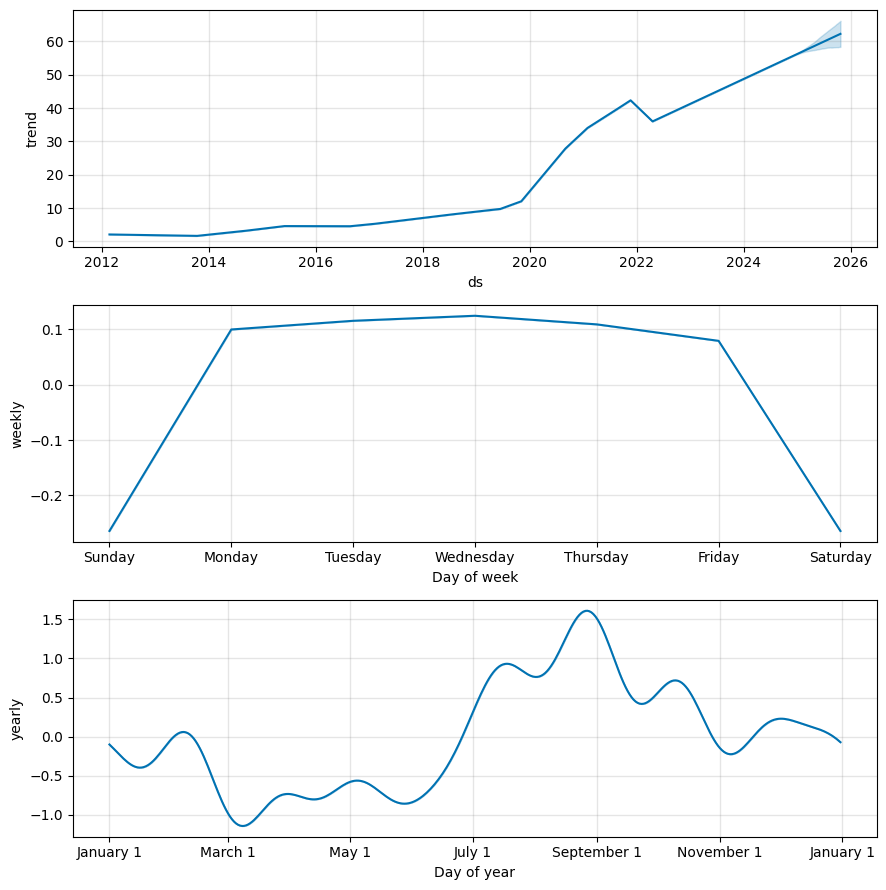

In [ ]:
from prophet import Prophet

# Conectar ao banco de dados
db_path = 'finance.bd'
conn = sqlite3.connect(db_path)

# Carregar todos os dados da tabela de históricos
historico_precos = pd.read_sql_query("SELECT Date, Close, Ticker FROM historico_precos;", conn)
conn.close()

# Garantir que a coluna de data esteja em formato datetime
historico_precos['Date'] = pd.to_datetime(historico_precos['Date'])

# Loop para analisar cada ativo individualmente
tickers = historico_precos['Ticker'].unique()
resultados_tendencias = {}

for ticker in tickers:
    # Filtrar os dados para o ticker específico
    dados_ticker = historico_precos[historico_precos['Ticker'] == ticker].copy()
    dados_ticker = dados_ticker[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

    # Aplicar o Prophet para prever tendências sazonais e anuais
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(dados_ticker)

    # Fazer previsões
    future = model.make_future_dataframe(periods=365)  # 1 ano para frente, ajuste conforme necessário
    forecast = model.predict(future)

    # Adicionar os dados de sazonalidade e tendências ao dicionário
    # Note que 'weekly' e 'yearly' dependem das configurações do Prophet e podem variar
    print(ticker)
    resultados_tendencias[ticker] = forecast[['ds', 'trend', 'weekly', 'yearly']]

    # Plotar as componentes (tendência e sazonalidade)
    model.plot_components(forecast)


## É possível prever, usando regressão, se uma ação vai subir ou descer?

Hipótese inicial: Ações não dependem apenas de dados históricos, como também são extremamente impactadas por fatores externos, como política, conflitos e outros aspectos econômicos. Mesmo que seja possível entender o comportamento de uma ação em específico, é muito difícil prever com exatidão qual será o comportamento dela, visto que "cisnes negros" ou outros eventos não probabilísticos podem ocorrer.